# 1. Choose a labeled text dataset used for classification

In [1]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
import re
from sklearn.metrics import  balanced_accuracy_score
from sklearn.model_selection import train_test_split
df = pd.read_csv('amazon_balanced.csv')
df["Sentiment"].value_counts()   # Unbalanced dataset

Sentiment
Positive    82037
Negative    82037
Name: count, dtype: int64

In [2]:
from tabulate import tabulate
def print_relevant_words(pipe):
    words = pipe['vectorizer'].get_feature_names_out()
    print("Vocabulary size", len(words))
    coefs = pipe['model'].coef_
    classes = pipe['model'].classes_

    top_n_words = 10
    sorted_coef_indexes = coefs.argsort(axis=1)

    negative_words = [(words[i], coefs[0, i]) for i in sorted_coef_indexes[0, :top_n_words]]
    positive_words = [(words[i], coefs[0, i]) for i in sorted_coef_indexes[0, -top_n_words:]]

    table = []
    for neg, pos in zip(negative_words, positive_words):
        table.append([f"{neg[0]} | relevance: {neg[1]:.2f}", f"{pos[0]} | relevance: {pos[1]:.2f}"])

    print(tabulate(table, headers=["Negative", "Positive"], tablefmt="grid"))

# 2. Define a classification pipeline and 3. Run and evaluate the classifier

In [3]:
X = df['Review']
label_mapping = {'Positive': 1, 'Negative': 0}
y = df['Sentiment'].map(label_mapping)   # 1 for positive, 0 for negative

In [4]:
from joblib import Parallel, delayed
import numpy as np

def get_train_test_accuracy(pipeline_factory, x_vector, y_vector):
    pipeline = pipeline_factory()
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(x_vector, y_vector, test_size=0.2)
    # Train the pipeline
    pipeline.fit(X_train, y_train)
    # Predict on training set
    y_train_pred = pipeline.predict(X_train)
    train_accuracy = balanced_accuracy_score(y_train, y_train_pred)
    
    # Predict on test set
    y_test_pred = pipeline.predict(X_test)
    test_accuracy = balanced_accuracy_score(y_test, y_test_pred)

    return train_accuracy, test_accuracy

def get_mean_accurancy(pipeline_factory, x_vector, y_vector, n=10, n_jobs = -1):
    results = Parallel(n_jobs=n_jobs)(delayed(get_train_test_accuracy)(pipeline_factory, x_vector, y_vector) for i in range(n))
    results = [result for result in results if result is not None]  # Ensure results are not None

    train_accuracies = np.array([train_accuracy for train_accuracy, _ in results])
    test_accuracies = np.array([test_accuracy for _, test_accuracy in results])
    mean_train_accuracies = np.mean(train_accuracies)
    mean_test_accuracies = np.mean(test_accuracies)

    return mean_train_accuracies, mean_test_accuracies

In [5]:
stop_words = [
"i",
"me",
"my",
"myself",
"we",
"our",
"ours",
"ourselves",
"you",
"your",
"yours",
"yourself",
"yourselves",
"he",
"him",
"his",
"himself",
"she",
"her",
"hers",
"herself",
"it",
"its",
"itself",
"they",
"them",
"their",
"theirs",
"themselves",
"what",
"which",
"who",
"whom",
"this",
"that",
"these",
"those",
"am",
"is",
"are",
"was",
"were",
"be",
"been",
"being",
"have",
"has",
"had",
"having",
"do",
"does",
"did",
"doing",
"a",
"an",
"the",
"and",
"but",
"if",
"or",
"because",
"as",
"until",
"while",
"of",
"at",
"by",
"for",
"with",
"about",
"against",
"between",
"into",
"through",
"during",
"before",
"after",
"above",
"below",
"to",
"from",
"up",
"down",
"in",
"out",
"on",
"off",
"over",
"under",
"again",
"further",
"then",
"once",
"here",
"there",
"when",
"where",
"why",
"how",
"all",
"any",
"both",
"each",
"few",
"more",
"most",
"other",
"some",
"such",
"no",
"nor",
"not",
"only",
"own",
"same",
"so",
"than",
"too",
"very",
"s",
"t",
"can",
"will",
"just",
"don",
"should",
"now",
]



In [6]:
def normal_pipeline_factory():
    return Pipeline(
        [
            (
                "vectorizer",
                CountVectorizer(
                    preprocessor=lambda x: re.sub(r"[^a-zA-Z\s]", " ", x.lower()),
                    strip_accents="ascii",
                    binary=True,
                    stop_words=stop_words,
                    min_df=20,
                ),
            ),
            ("model", LogisticRegression(max_iter=1000)),
        ]
    )

In [7]:
pipe_count_binary = normal_pipeline_factory()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

pipe_count_binary.fit(X_train, y_train)
print("Pipe score: ", pipe_count_binary.score(X_test, y_test))
y_pred = pipe_count_binary.predict(X_test)
accuracy = balanced_accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy)
print_relevant_words(pipe_count_binary)
n = 20
train_accuracy, test_accurancy = get_mean_accurancy(normal_pipeline_factory, X, y, n)
print(f"Train accuracy: {train_accuracy:.3f}, Test accuracy: {test_accurancy:.3f} over {n} runs")

Pipe score:  0.8930062471430749
Accuracy:  0.8930072068701127
Vocabulary size 10966
+----------------------------------+---------------------------------+
| Negative                         | Positive                        |
+==================================+=================================+
| dissapointing | relevance: -2.99 | divine | relevance: 2.06        |
+----------------------------------+---------------------------------+
| overrated | relevance: -2.87     | addicting | relevance: 2.07     |
+----------------------------------+---------------------------------+
| yuck | relevance: -2.85          | jimmies | relevance: 2.09       |
+----------------------------------+---------------------------------+
| boo | relevance: -2.81           | snickerdoodle | relevance: 2.10 |
+----------------------------------+---------------------------------+
| cancelled | relevance: -2.59     | hooked | relevance: 2.15        |
+----------------------------------+----------------------------

## Lemmatized pipeline (selected as best)

In [8]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
X_lemmatized = X.apply(lambda x: ' '.join([lemmatizer.lemmatize(p) for p in x.lower().split()]))
lemmatized_stop_words = [lemmatizer.lemmatize(word) for word in stop_words]

In [9]:
def lemma_pipeline_factory():
    return Pipeline(
    [
        (
            "vectorizer",
            CountVectorizer(
                strip_accents="ascii",
                preprocessor=lambda x: re.sub(r"[^a-zA-Z\s]", " ", x.lower()),
                binary=True,
                stop_words=lemmatized_stop_words,
                min_df=20,
            ),
        ),
        ("model", LogisticRegression(max_iter=1000)),
    ]
)

In [10]:
X_train_lemmatized, X_test_lemmatized, y_train_lemmatized, y_test_lemmatized = (
    train_test_split(X_lemmatized, y, test_size=0.2, random_state=0)
)

pipe_lemma_count_binary = lemma_pipeline_factory()
pipe_lemma_count_binary.fit(X_train_lemmatized, y_train_lemmatized)
print(
    "Pipe score: ", pipe_lemma_count_binary.score(X_test_lemmatized, y_test_lemmatized)
)
y_pred_lemmatized = pipe_lemma_count_binary.predict(X_test_lemmatized)
accuracy = balanced_accuracy_score(y_test_lemmatized, y_pred_lemmatized)
print("Accuracy: ", accuracy)
print_relevant_words(pipe_lemma_count_binary)
n = 10
train_accuracy, test_accurancy = get_mean_accurancy(lemma_pipeline_factory, X_lemmatized, y, n)
print(f"Train accuracy: {train_accuracy:.3f}, Test accuracy: {test_accurancy:.3f} over {n} runs")

Pipe score:  0.8897150693280512
Accuracy:  0.8897155670949362
Vocabulary size 9784
+----------------------------------+--------------------------------+
| Negative                         | Positive                       |
+==================================+================================+
| overrated | relevance: -3.19     | addictive | relevance: 1.98    |
+----------------------------------+--------------------------------+
| dissapointing | relevance: -2.86 | nutritionist | relevance: 1.99 |
+----------------------------------+--------------------------------+
| yuck | relevance: -2.73          | hooked | relevance: 1.99       |
+----------------------------------+--------------------------------+
| boo | relevance: -2.71           | yum | relevance: 2.05          |
+----------------------------------+--------------------------------+
| yikes | relevance: -2.67         | skeptical | relevance: 2.08    |
+----------------------------------+--------------------------------+
| weake

## Stemmed pipeline

In [11]:
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer("english")
X_stemmed = X.apply(lambda x: ' '.join([stemmer.stem(p) for p in x.lower().split()]))
stemmed_stop_words = [stemmer.stem(word) for word in stop_words]

In [12]:
def stem_pipeline_factory():
    return Pipeline(
    [
        (
            "vectorizer",
            CountVectorizer(
                preprocessor=lambda x: re.sub(r"[^a-zA-Z\s]", " ", x.lower()),
                strip_accents="ascii",
                binary=True,
                stop_words=stemmed_stop_words,
                min_df=20,
            ),
        ),
        ("model", LogisticRegression(max_iter=1000)),
    ]
)

In [13]:
pipe_stemmed_count = stem_pipeline_factory()

X_train_stemmed, X_test_stemmed, y_train_stemmed, y_test_stemmed = train_test_split(
    X_stemmed, y, test_size=0.2
)

pipe_stemmed_count.fit(X_train_stemmed, y_train_stemmed)
print("Pipe score: ", pipe_stemmed_count.score(X_test_stemmed, y_test_stemmed))
y_pred_stemmed = pipe_stemmed_count.predict(X_test_stemmed)
accuracy = balanced_accuracy_score(y_test_stemmed, y_pred_stemmed)
print("Accuracy: ", accuracy)
print_relevant_words(pipe_stemmed_count)
n = 20
train_accuracy, test_accurancy = get_mean_accurancy(stem_pipeline_factory, X_stemmed, y, n)
print(f"Train accuracy: {train_accuracy:.3f}, Test accuracy: {test_accurancy:.3f} over {n} runs")


Pipe score:  0.8852049367667225
Accuracy:  0.8852586446371988
Vocabulary size 7760
+-------------------------------+---------------------------+
| Negative                      | Positive                  |
+===============================+===========================+
| boo | relevance: -2.92        | leap | relevance: 1.93    |
+-------------------------------+---------------------------+
| unfinish | relevance: -2.72   | vouch | relevance: 1.97   |
+-------------------------------+---------------------------+
| yuck | relevance: -2.70       | reassur | relevance: 1.97 |
+-------------------------------+---------------------------+
| overr | relevance: -2.70      | jimmi | relevance: 2.02   |
+-------------------------------+---------------------------+
| worst | relevance: -2.55      | woof | relevance: 2.03    |
+-------------------------------+---------------------------+
| aerogarden | relevance: -2.51 | downsid | relevance: 2.07 |
+-------------------------------+----------------

### Selected Pipeline: CountVectorizer, Lemmatization and Logistic Regression
#### Reasons 
* Better interpretability
* Smaller vocabulary, less dimensionality
* Small differences between classifier mean accuracy.

# 4. Assess the dataset size

In [14]:
from joblib import Parallel, delayed
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer


f_list = np.logspace(0, -2.5, 30)

# Function to process one fraction f
def process_fraction(x_vector, y_vector, f, n=50):
    # Sample the dataset
    if float(f) == 1.0:
            X_sample, y_sample = x_vector, y_vector
    else:
        X_sample, _, y_sample, _ = train_test_split(x_vector, y_vector, train_size=float(f))
    train_accuracy, test_accuracy = get_mean_accurancy(lemma_pipeline_factory, X_sample, y_sample, n, n_jobs=-1)

    # Return the average accuracies for this fraction f
    print("Processed fraction", f)
    return train_accuracy, test_accuracy

def get_accuracy_sample(x_vector, y_vector, f_list):
    # Resample the dataset using .sample(frac=f), which gets a fraction of the dataset
    results = Parallel(n_jobs=-1)(delayed(process_fraction)(x_vector, y_vector, f) for f in f_list)
    
    # Separate the train and test accuracies
    train_accuracies, test_accuracies = zip(*results)
    
    return train_accuracies, test_accuracies

train_accuracies, test_accuracies = get_accuracy_sample(X_lemmatized, y, f_list)

Processed fraction 0.11264816923358861
Processed fraction 0.13738237958832628
Processed fraction 0.1675474918923341
Processed fraction 0.20433597178569418
Processed fraction 0.09236708571873861
Processed fraction 0.07573739175895006
Processed fraction 0.06210169418915616
Processed fraction 0.041753189365604
Processed fraction 0.0342359795760758
Processed fraction 0.24920211513780569
Processed fraction 0.05092095636773397
Processed fraction 0.028072162039411756
Processed fraction 0.015475873545578884
Processed fraction 0.01268961003167922
Processed fraction 0.018873918221350965
Processed fraction 0.023018073130224664
Processed fraction 0.010404983103657853
Processed fraction 0.005736152510448676
Processed fraction 0.006995642156712626
Processed fraction 0.008531678524172805
Processed fraction 0.00470342034169863
Processed fraction 0.0031622776601683794
Processed fraction 0.0038566204211634724
Processed fraction 0.30391953823131973
Processed fraction 0.3706512910922155
Processed fraction

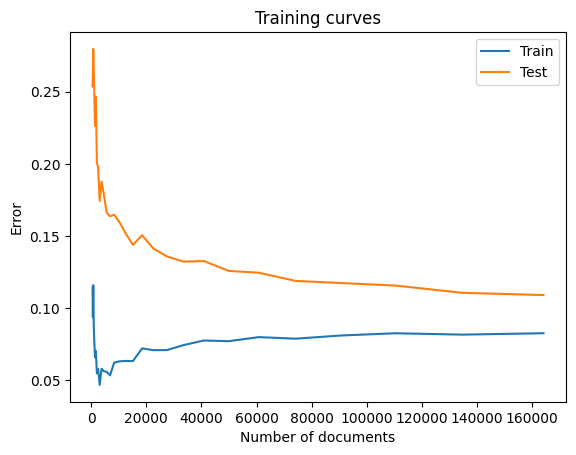

In [15]:
import matplotlib.pyplot as plt

error_train = [1 - x for x in train_accuracies]
error_test = [1 - x for x in test_accuracies]

plt.plot(f_list * len(df), error_train, label='Train')
plt.plot(f_list * len(df), error_test, label='Test')
plt.xlabel('Number of documents')
plt.ylabel('Error')

plt.title("Training curves")
plt.legend()

# 5. Use topic models to refine your answers

In [16]:
def print_words_in_topics(nmf, vectorizer):
    words = vectorizer.get_feature_names_out()
    for idx, topic in enumerate(nmf.components_):
        print(f"Topic {idx}")
        for i in topic.argsort()[-10:]:
            print(words[i])
        print()
    print()

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import NMF

def topic_pipeline_factory():
    return Pipeline([
            ("vectorizer",
            CountVectorizer(
                strip_accents="ascii",
                preprocessor=lambda x: re.sub(r"[^a-zA-Z\s]", " ", x.lower()),
                binary=True,
                stop_words=lemmatized_stop_words,
                min_df=20,
            ),
        ),
        ('nmf', NMF(n_components=4))])

vectorizer_nmf_pipeline = topic_pipeline_factory()
X_nmf = vectorizer_nmf_pipeline.fit_transform(X_lemmatized)

In [18]:
print_words_in_topics(vectorizer_nmf_pipeline['nmf'], vectorizer_nmf_pipeline['vectorizer'])

Topic 0
dont
even
buy
amazon
food
get
time
would
one
product

Topic 1
best
old
tried
eating
stuff
year
day
cat
eat
food

Topic 2
drink
one
tried
dont
really
coffee
good
flavor
taste
like

Topic 3
find
snack
store
amazon
flavor
best
price
good
love
great




(array([58371.,  3252., 57215., 45236.]),
 array([0.  , 0.75, 1.5 , 2.25, 3.  ]),
 <BarContainer object of 4 artists>)

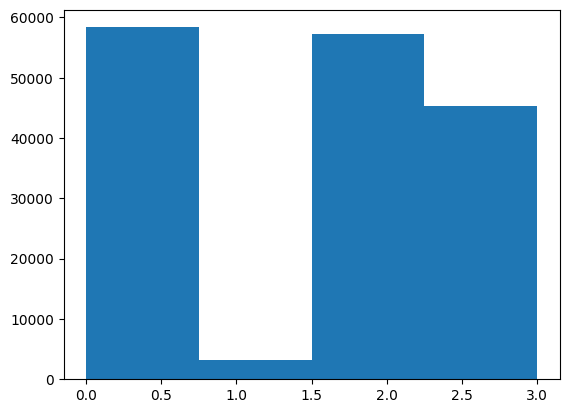

In [19]:
import numpy as np
import matplotlib.pyplot as plt

topic = np.argmax(X_nmf, axis=1)
plt.hist(topic, bins=len(set(topic)))

### Training two step classifier

In [20]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np

class TwoLayerClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, topic_pipeline, topic_classifiers):
        self.topic_pipeline = topic_pipeline  # Pipeline for topic classification
        self.topic_classifiers = topic_classifiers  # Dictionary for topic-specific classifiers

    def fit(self, X, y):
        self.topic_pipeline.fit(X)

        # Predict topics for the training set
        topic_distributions = self.topic_pipeline.transform(X)
        topics = topic_distributions.argmax(axis=1)

        # Fit a classifier for each topic
        for topic in np.unique(topics):
            topic_docs = X[topics == topic]
            topic_labels = y[topics == topic]
            self.topic_classifiers[topic].fit(topic_docs, topic_labels)

        return self

    def predict(self, X):
        topic_distributions = self.topic_pipeline.transform(X)
        topics = topic_distributions.argmax(axis=1)

        predictions = np.zeros(len(X), dtype=int)
        for i, topic in enumerate(topics):
            classifier = self.topic_classifiers[topic]
            prediction = classifier.predict([X[i]])
            predictions[i] = prediction[0]

        return predictions

    def score(self, X, y):
        predictions = self.predict(X)
        return accuracy_score(y, predictions)

# Initialize topic-specific classifiers (1 classifier per topic)
topic_classifiers = {i: lemma_pipeline_factory() for i in range(4)}
topic_pipeline = topic_pipeline_factory()

two_layer_classifier = TwoLayerClassifier(topic_pipeline, topic_classifiers)

X_train, X_test, y_train, y_test = train_test_split(X_lemmatized, y, test_size=0.2, random_state=42)

two_layer_classifier.fit(X_train, y_train)

y_pred = two_layer_classifier.predict(X_test.to_numpy())

# Calculate the classification accuracy for each topic
X_test_topic_distributions = topic_pipeline.transform(X_test)
X_test_topics = X_test_topic_distributions.argmax(axis=1)

topic_accuracies = {}
for topic in np.unique(X_test_topics):
    # Get indices of documents belonging to the current topic
    topic_indices = np.where(X_test_topics == topic)[0]
    
    # Get true labels and predicted labels for documents in the current topic
    y_true_topic = np.array(y_test)[topic_indices]
    y_pred_topic = np.array(y_pred)[topic_indices]
    
    # Calculate accuracy for the current topic
    if len(y_true_topic) > 0:  # Avoid division by zero for empty topics
        accuracy = accuracy_score(y_true_topic, y_pred_topic)
        topic_accuracies[topic] = accuracy

# Print classification accuracies for each topic
for topic, accuracy in topic_accuracies.items():
    print(f"Topic {topic}: Accuracy = {accuracy:.4f}")

print_words_in_topics(topic_pipeline["nmf"], topic_pipeline["vectorizer"])

Topic 0: Accuracy = 0.8817
Topic 1: Accuracy = 0.8965
Topic 2: Accuracy = 0.8779
Topic 3: Accuracy = 0.9188
Topic 0
dont
even
buy
amazon
food
get
time
would
one
product

Topic 1
diet
old
tried
stuff
eating
year
day
cat
eat
food

Topic 2
drink
one
tried
dont
really
coffee
good
flavor
taste
like

Topic 3
find
snack
store
amazon
flavor
best
price
good
love
great




* Topic 0: Reviews about generic food products
* Topic 1: Reviews about cat food
* Topic 2: Reviews about coffee
* Topic 3: Reviews about snacks